# LINMA1702 modèles et méthodes d'optimisation
# Projet 2020-2021 : Logistique de la vaccination en Belgique
### Groupe 6 : Théau Lepouttre, Eliott Van Dieren et Nicolas Mil-Homens Cavaco


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mip import *

### Hypothèses

On considère un certaine population répartie en $m$ classes d'âge dans $n$ provinces en Belgique.
Parmi les personnes constituant cette population, on distingue $2$ parties disjointes:

* les personnes susceptibles 
* les autres, c'est-à-dire les malades, les vaccinés, les guéris et les morts.
    
On suppose cette population comme constante dans le temps.
Notre objectif est de minimiser le nombre de morts dû à l'épidémie.

### Question 1.1

Dans ce premier modèle, on considère le cas d'un seul centre ($n=1$).
En outre, le stockage des vaccins n'est pas autorisé.
On suppose également que la durée de la campagne de vaccination s'étant sur une durée de $T$ jours.

Soit les variables suivantes

* $x^t \equiv$ le nombre de doses qui arrivent au centre de vaccination au temps $t$; 
* $y_i^t \equiv$ le nombre de doses administrées à la classe d'âge $i$ au temps $t$;

contraintes par les paramètres suivants,

* $b_c^t \equiv$ le nombre de vaccins livrés dans l'entrepôt central;
* $b_l^t \equiv$ le nombre maximal de vaccins livrés au temps $t$;
* $b_v^t \equiv$ le nombre maximal de vaccins administrés au temps $t$;
* $c_{tr} \equiv$ le coût de transport;
* $c_v \equiv$ le coût de vaccination;
* $c_{tot} \equiv$ le budget total disponible;

Soit 

* $\lambda_i^t \equiv$ la fraction parmi les personnes susceptibles tombant malade au jour $t$ pour la classe $i$.
* $\varepsilon_i^t \equiv$ la fraction parmi les personnes de la classe $i$ tombées malades au jour $t$ qui décèderont.
* $\mu_i \equiv$ la fraction de population disposée et autorisée à se faire vacciner


* $(n_s)_i^t \equiv$ le nombre de personnes susceptibles parmi les personnes de la classe $i$ au temps $t$;
* $(n_m)_i^t \equiv$ le nombre de personnes de la classe $i$ qui sont tombées malade au temps $t$;
* $(n_v)_i^t \equiv$ le nombre de personnes vaccinées pour une classe $i$ au temps $t$.

On a 
$$\begin{eqnarray*}
(n_v)_i^t &=& y_i^t \\
(n_m)_i^t &=& \lambda_i^t\ (n_s)_i^t \\
(n_s)_i^t &=& (n_s)_i^{t-1} - (n_m)_i^{t-1} - (n_v)_i^{t-1} = (1-\lambda_i^t)\ (n_s)_i^{t-1} - y_i^{t-1}
\end{eqnarray*}$$
On identifie les contraintes suivantes:
* Le budget total de la campagne de vaccination est limité.
* Le total de vaccins administrés au temps $t$ ne peut pas dépasser le nombre total de vaccins livrés la veille, et ce sur toute la durée de la campagne.
* Le nombre de vaccins livrés est limité chaque jour par le nombre de vaccins disponibles dans l'entrepôt central.
* Le nombre de vaccins livrés est limité chaque jour par la limite du centre de vaccination.
* Le nombre de vaccins administrés est limité chaque jour.
* Seules les personnes disposées et autorisées peuvent se faire vacciner (18+ et consentant). 

Finalement, on prend la convention que $x^0 = 0 = x^T$, en d'autres termes aucun vaccin n'a été livré la veille du début de la campagne ou ne doit être livré le dernier jour.

Le problème s'écrit donc

$$\begin{eqnarray*}
\min_{x, y}& \sum_{t=1}^{T} \sum_{i=1}^{m}  \varepsilon_i^t\ \lambda_i^t\ (n_s)_i^t \\
\sum_{t=1}^T \left(c_{tr}\ x^t + c_v \sum_{i=1}^{m} y_i^t\right) &\leq& c_{tot} \\
x^{t-1} - \sum_{i=1}^{m} y_i^t &\geq& 0 \qquad t \in \{2, \ldots, T\}\\
x^{t} &\leq & b_c^t \\  
x^t &\leq& b_l^t \\
\sum_{i=1}^{m} y_i^t &\leq&\ b_v^t \\
y_i^t &\leq& \mu_i\ (n_s)_i^t \\ %(n_s)_i^t - (n_{nv})_i^t \\
x,\ y &\geq& 0
\end{eqnarray*}$$

In [2]:
# Données du problème

T = 350               # durée de la campagne
m = 5                 # nombre de classes d'âge : [Young, Adult, Senior, Old, Centenarian]
c_tr  = 0             # Prix de livraison d'un vaccin
c_v   = 15            # prix d'administration d'un vaccin
c_tot = 100e6         # budget total autorisé
b_l   = float("inf")  # nombre maximal de vaccins livrés par jour
b_v   = 14646         # nombre maximal de vaccins administrés par jour

lambda_t = lambda t: np.array([0.000298 * (1/5 + np.sin(t/50-1/5)**2),
                               0.000301 * (1/5 + np.sin(t/50)**2),
                               0.000204 * (1/5 + np.sin(t/50-1/5)**2),
                               0.000209 * (1/5 + np.sin(t/50-2/5)**2),
                               0.000329 * (1/5 + np.sin(t/50-2/5)**2)])

epsilon_t = lambda t: np.array([0.000100 * (6/5-t/1000),
                                0.000400 * (6/5-t/1000), 
                                0.005790 * (6/5-t/1000), 
                                0.027179 * (6/5-t/1000),
                                0.150000 * (6/5-t/1000)])

mu  = np.array([0.3, 0.6, 0.7, 0.9, 0.9])     # proportion de la population disposée à se faire vacciner.

b_c = np.zeros(T);
days = np.arange(1, T+1)
b_c_eff =  [80000, 80000,60000, 60000, 40000, 40000, 40000, 40000, 60000,60000,60000,60000,80000,80000,80000,
            80000,100000,100000,100000,100000,100000,100000,100000,100000,120000,120000,120000,120000,120000,
            120000,120000,120000,120000,120000,120000,120000,150000,150000,150000,150000,150000,150000,150000,
            150000,150000,150000,150000,150000,150000,150000]

for t in days-1:
    if(t != 0 and t % 7 == 0):
        b_c[t-1] = b_c_eff[t//7]

b_c[-1] = b_c_eff[-1] # /!\: à modifier

_lambda  = lambda_t(days)
_epsilon = epsilon_t(days)

print(b_c)


[     0.      0.      0.      0.      0.      0.  80000.      0.      0.
      0.      0.      0.      0.  60000.      0.      0.      0.      0.
      0.      0.  60000.      0.      0.      0.      0.      0.      0.
  40000.      0.      0.      0.      0.      0.      0.  40000.      0.
      0.      0.      0.      0.      0.  40000.      0.      0.      0.
      0.      0.      0.  40000.      0.      0.      0.      0.      0.
      0.  60000.      0.      0.      0.      0.      0.      0.  60000.
      0.      0.      0.      0.      0.      0.  60000.      0.      0.
      0.      0.      0.      0.  60000.      0.      0.      0.      0.
      0.      0.  80000.      0.      0.      0.      0.      0.      0.
  80000.      0.      0.      0.      0.      0.      0.  80000.      0.
      0.      0.      0.      0.      0.  80000.      0.      0.      0.
      0.      0.      0. 100000.      0.      0.      0.      0.      0.
      0. 100000.      0.      0.      0.      0.   

In [40]:
# Résolution du problème
model = Model('centre unique', sense=MINIMIZE, solver_name=CBC)

# Variables
x = np.array( [model.add_var(var_type=INTEGER, lb=0) for t in days-1])
y = np.array([[model.add_var(var_type=INTEGER, lb=0) for t in days-1] for i in range(m)])


# nombre de personnes susceptibles dans chaque classe d'âge
n_s = [[3778123, 2846993, 2790883, 1390502, 111533]]  
for t in range(1, len(days)):
    n_s.append([(1 - _lambda[i,t]) * n_s[t-1][i] - y[i, t-1] for i in range(m)])
    
# Objectif
model.objective = minimize(xsum(_epsilon[i,t] * _lambda[i,t] * n_s[t][i] for i in range(m) for t in days-1))

# Contraintes
model += xsum(c_tr * x) + xsum(c_v * y[i,t] for i in range(m) for t in days-1) <= c_tot
for t in days-1:
    if t > 1: 
        model += x[t-1] - xsum(y[:,t]) >= 0
    model += x[t] <= b_c[t]
    model += xsum(y[:,t]) <= b_v
    for i in range(m):
        model += y[i,t] - mu[i] * n_s[t][i] <= 0

model.optimize()

# print(f"x = {[x[t].x for t in days-1]}")
# print("\n")
# print(f"y = {[[y[i,t].x for i in range(m)] for t in days-1]}")


<OptimizationStatus.OPTIMAL: 0>

In [41]:
# print(f"y = {[[y[i,t].x for i in range(m)] for t in days-1]}")
# print(f"x = {[x[t].x for t in days-1]}")
print(f"f(x,y) = {model.objective_value}")

f(x,y) = 2360.325109488201


In [42]:
# Plot des résultats
population  = ["Young 0-29 ans", "Adult 30-49 ans", "Senior 50-69 ans", "Old 70-89 ans", "Centenarian 90-   ans"]
livraisons  = [x[t].x for t in days-1]
vaccination = [[y[i,t].x for t in days-1] for i in range(m)]
susceptible = [[n_s[t][i].x for t in days[1:-1]] for i in range(m)]
pop_s       = [sum(n_s[t][i].x for i in range(m)) for t in days[1:-1]]
pop_malade  = [sum( _lambda[i,t] * n_s[t][i].x for i in range(m)) for t in days[1:-1]]
pop_morte   = [sum(_epsilon[i,t] * _lambda[i,t] * n_s[t][i].x for i in range(m)) for t in days[1:-1]]

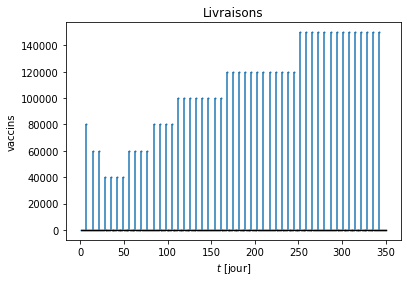

In [43]:
# Plot des livraisons
plt.figure()
plt.title("Livraisons")
markerline, stemlines, baseline = plt.stem(days, livraisons)
plt.xlabel("$t$ [jour]", fontsize=10)
plt.ylabel("vaccins", fontsize=10)
baseline.set_color('k')
baseline.set_linewidth(1)
markerline.set_markersize(1)
plt.show()   

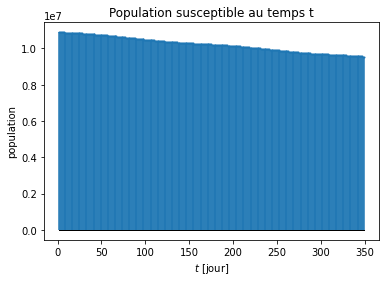

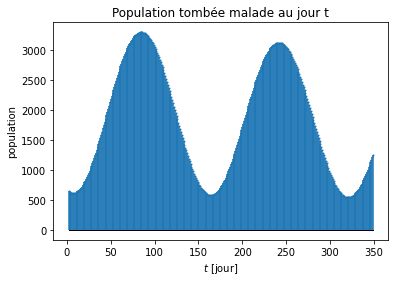

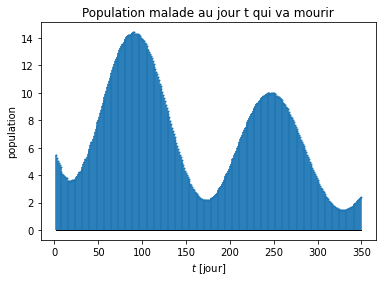

In [44]:
# Plot des populations
pop = [pop_s, pop_malade, pop_morte]
titres_pop = ["Population susceptible au temps t", "Population tombée malade au jour t", "Population malade au jour t qui va mourir"]
plt.figure()
for i in range(3):
    plt.title(titres_pop[i])
    markerline, stemlines, baseline = plt.stem(days[1:-1], pop[i])
    plt.xlabel("$t$ [jour]", fontsize=10)
    plt.ylabel("population", fontsize=10)
    baseline.set_color('k')
    baseline.set_linewidth(1)
    markerline.set_markersize(1)
    plt.show()

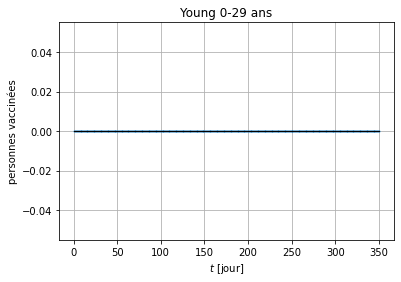

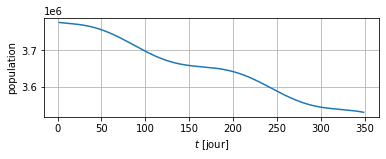

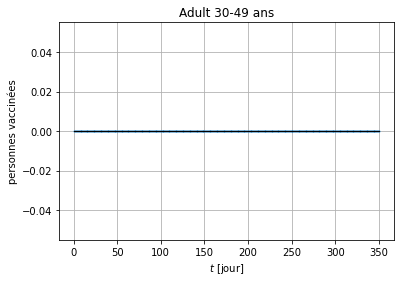

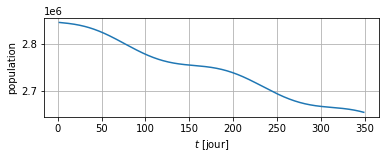

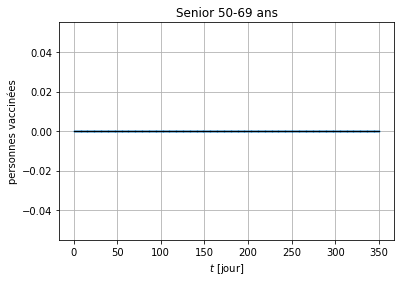

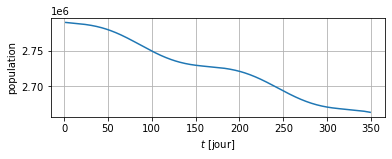

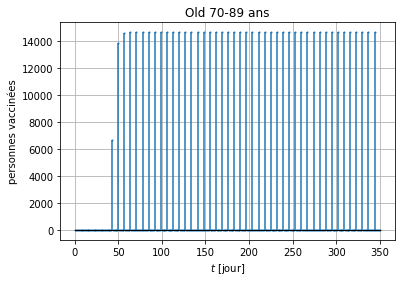

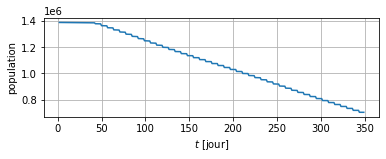

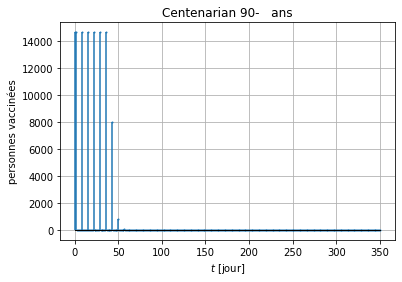

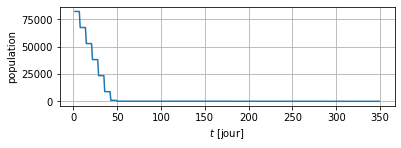

In [45]:
# Titres
titres = [f"{population[i]}" for i in range(m)]

plt.figure("Question 1.1")
for i in range(5):
        plt.subplot(1, 1, 1)
        plt.title(titres[i])
        markerline, stemlines, baseline = plt.stem(days, vaccination[i])       
        plt.xlabel("$t$ [jour]", fontsize=10)
        plt.ylabel("personnes vaccinées", fontsize=10)

        baseline.set_color('k')
        baseline.set_linewidth(1)
        markerline.set_markersize(1)
        plt.grid()
        plt.show()
        
        plt.subplot(2, 1, 2)
        plt.plot(days[1:-1], susceptible[i])
        plt.xlabel("$t$ [jour]", fontsize=10)
        plt.ylabel("population", fontsize=10)
        plt.grid()
        plt.show()

### Question 1.2

On considère à présent le cas de $n$ provinces. Dans le cas de la Belgique, on aura $n=10$.
On autorise également le stockage des vaccins dans les centres.

Par rapport au modèle précédent, on introduit 
* $z_j^t \equiv$ le nombre de vaccins stockés au temps $t$ dans le centre de la province $j$, variable. Ces vaccins ne sont donc pas administrés au jour $t$.
* $(c_s)_j \equiv$ le coût associé au stockage d'un vaccin dans le centre $j$, connu.

Outre les contraintes identifiées plus haut, on ajoute le fait que le nombre de vaccins administrés au temps $t$ ne peut dépasser le nombre de vaccins livrés la veille et ceux en stocks la veille également.

Finalement, puisqu'on suppose que chaque province $j$ subit l'épidémie de manière indépendante, les contraintes sont propres à chacune, excepté la contrainte de coût total.

Le problème s'écrit donc

$$\begin{eqnarray*}
\max_{x, y, z}& \sum_{t=1}^{T} \sum_{i=1}^{m} \sum_{j=1}^{n} \varepsilon_{ij}^t\ \lambda_{ij}^t (n_s)_{ij}^t\ y_{ij}^t & \\
\sum_{t=1}^T \sum_{j=1}^{n} \left(c_{tr}\ x_j^t + c_v \sum_{i=1}^{m} y_{ij}^t + c_s z_j^t\right) &\leq& c_{tot} \\
x_j^{t-1} + z_j^{t-1} - \sum_{i=1}^{m} y_{ij}^t &\geq& 0 \\
\left(\sum_{k=1}^t x_j^{k}\right) - z_j^{t} &\geq& 0 \\
\sum_{j=1}^n x_j^{t} &\leq & b_c^t \\ 
x_j^t &\leq& (b_l)_j^t \\
\sum_{i=1}^{m} y_{ij}^t &\leq&\ (b_v)_j^t \\
y_{ij}^t &\leq& \mu_{ij}^t\ (n_m)_{ij}^t \\
x,\ y,\ z &\geq& 0
\end{eqnarray*}$$

In [ ]:
# Données du problème
frac_malade_province = pd.read_csv("Données-v1.1/Fraction_malade_province.csv")
frac_malade_province = frac_malade_province.set_index('Tranche')

population_Province = pd.read_csv("Données-v1.1/Population_province.csv")
arrays = [population_Province["Province"], population_Province["Tranche"]]
index = pd.MultiIndex.from_tuples(list(zip(*arrays)), names=["Province","Tranche"])
population_Province = pd.Series(population_Province["Population"].to_numpy(),index)
population_Province

In [ ]:
# Résolution du problème
model = Model('centre unique', sense=MINIMIZE, solver_name=CBC)

# Variables
x = np.array( [model.add_var(var_type=INTEGER, lb=0) for t in days-1])
y = np.array([[model.add_var(var_type=INTEGER, lb=0) for t in days-1] for i in range(m)])


# nombre de personnes susceptibles dans chaque classe d'âge
n_s = [[3778123, 2846993, 2790883, 1390502, 111533]]
n_m = [[0]*m]
n_v = [y[:,0]]   
for t in range(1, len(days)):
    n_v.append([n_v[t-1][i] + y[i,t] for i in range(m)])
    n_s.append([n_s[0][i] - n_m[t-1][i] - n_v[t-1][i] for i in range(m)])
    n_m.append([n_m[t-1][i] + _lambda[i,t] * n_s[t][i] - _epsilon[i,t-1] * n_m[t-1][i] for i in range(m)])
    
# Objectif
model.objective = minimize(xsum(_epsilon[i,t] * n_s[t][i] for i in range(m) for t in days-1))

# Contraintes
model += xsum(c_tr * x) + xsum(c_v * y[i,t] for i in range(m) for t in days-1) <= c_tot
for t in days-1:
    if t > 1: 
        model += x[t-1] - xsum(y[:,t]) >= 0
    model += x[t] <= b_c[t]
    model += xsum(y[:,t]) <= b_v
    for i in range(m):
        model += y[i,t] - mu[i] * n_s[t][i] <= 0

model.optimize()

# print(f"x = {[x[t].x for t in days-1]}")
# print("\n")
# print(f"y = {[[y[i,t].x for i in range(m)] for t in days-1]}")